In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt

In [93]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, total_data = 19800, transform=True):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.total_data = total_data
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 198 data by file, 1000 files(from 0 to 999), total data: 198*100 = 19800
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = (index//199)%199  # because there 198 data per file
            index_t = (index-199)%199
            
            # Input data: Wavepacket real and imaginary part + Potential at time t
            x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).real
            x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).imag
            x_p = np.load(self.data+str(index_data)+'/Potential/'+str(index_t)+'-potential.npy')
            # Output data: Wavepacket real and imaginary part at time t+1*step
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).imag
        
            x = np.concatenate((x_r, x_i, x_p))  # flat array form

            y = np.concatenate((y_r, y_i))  # flat array form
        
            if self.transform:
                x = torch.from_numpy(x)
                y = torch.from_numpy(y)
        
            return x, y
    
    def __len__(self):
        
        
        return self.total_data



In [94]:
dataset = Propagator_Dataset(data='../../Data_Gaussian/data', targets='../../Data_Gaussian/data', transform=True)
batch_size = 16
validation_split = .1  #9:1 ratio
shuffle_dataset = True
random_seed= 42

In [95]:
dataset_size = len(dataset)
print('Total de datos: ', dataset_size)



Total de datos:  19800


In [96]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)



In [97]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [98]:

for X, y in validation_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 96])
Shape of y: torch.Size([16, 64]) torch.float64


In [99]:
device = "cpu"
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(96, 1024),
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(1024, 64)
        )
        
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
  )
)


In [100]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [101]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [104]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += 100#(pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [112]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(validation_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.079031  [    0/19800]
loss: 0.084281  [ 1600/19800]
loss: 0.073313  [ 3200/19800]
loss: 0.080054  [ 4800/19800]
loss: 0.078907  [ 6400/19800]
loss: 0.078857  [ 8000/19800]
loss: 0.077837  [ 9600/19800]
loss: 0.078013  [11200/19800]
loss: 0.075561  [12800/19800]
loss: 0.077015  [14400/19800]
loss: 0.080203  [16000/19800]
loss: 0.080015  [17600/19800]
Test Error: 
 Accuracy: 62.6%, Avg loss: 0.078777 

Epoch 2
-------------------------------
loss: 0.079406  [    0/19800]
loss: 0.082857  [ 1600/19800]
loss: 0.074949  [ 3200/19800]
loss: 0.076019  [ 4800/19800]
loss: 0.084499  [ 6400/19800]
loss: 0.077637  [ 8000/19800]
loss: 0.080135  [ 9600/19800]
loss: 0.079414  [11200/19800]
loss: 0.080000  [12800/19800]
loss: 0.081166  [14400/19800]
loss: 0.078717  [16000/19800]
loss: 0.075915  [17600/19800]
Test Error: 
 Accuracy: 62.6%, Avg loss: 0.078225 

Epoch 3
-------------------------------
loss: 0.076954  [    0/19800]
loss: 0.077052  [ 1600/198

loss: 0.070966  [ 1600/19800]
loss: 0.073641  [ 3200/19800]
loss: 0.067274  [ 4800/19800]
loss: 0.068246  [ 6400/19800]
loss: 0.069557  [ 8000/19800]
loss: 0.063021  [ 9600/19800]
loss: 0.073257  [11200/19800]
loss: 0.074786  [12800/19800]
loss: 0.077618  [14400/19800]
loss: 0.068988  [16000/19800]
loss: 0.067140  [17600/19800]
Test Error: 
 Accuracy: 62.6%, Avg loss: 0.071500 

Epoch 20
-------------------------------
loss: 0.065415  [    0/19800]
loss: 0.070423  [ 1600/19800]
loss: 0.076891  [ 3200/19800]
loss: 0.072024  [ 4800/19800]
loss: 0.069445  [ 6400/19800]
loss: 0.070347  [ 8000/19800]
loss: 0.067755  [ 9600/19800]
loss: 0.071037  [11200/19800]
loss: 0.069727  [12800/19800]
loss: 0.064211  [14400/19800]
loss: 0.076946  [16000/19800]
loss: 0.078646  [17600/19800]
Test Error: 
 Accuracy: 62.6%, Avg loss: 0.071227 

Epoch 21
-------------------------------
loss: 0.065999  [    0/19800]
loss: 0.068453  [ 1600/19800]
loss: 0.075921  [ 3200/19800]
loss: 0.070387  [ 4800/19800]
loss

In [19]:
  # Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}\n-------------------------------")
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
      
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        #targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = model(inputs)
      
        # Compute loss
        loss = loss_fn(outputs, targets)
      
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
            current_loss = 0.0

  # Process is complete.
#print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.000
Loss after mini-batch    11: 0.002
Loss after mini-batch    21: 0.002
Loss after mini-batch    31: 0.002
Loss after mini-batch    41: 0.002
Loss after mini-batch    51: 0.002
Loss after mini-batch    61: 0.002
Loss after mini-batch    71: 0.002
Loss after mini-batch    81: 0.002
Loss after mini-batch    91: 0.002
Loss after mini-batch   101: 0.002
Loss after mini-batch   111: 0.002
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.002
Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.002
Los

Loss after mini-batch  2341: 0.002
Loss after mini-batch  2351: 0.002
Loss after mini-batch  2361: 0.002
Loss after mini-batch  2371: 0.002
Loss after mini-batch  2381: 0.002
Loss after mini-batch  2391: 0.002
Loss after mini-batch  2401: 0.002
Loss after mini-batch  2411: 0.002
Loss after mini-batch  2421: 0.002
Loss after mini-batch  2431: 0.002
Loss after mini-batch  2441: 0.002
Loss after mini-batch  2451: 0.002
Loss after mini-batch  2461: 0.002
Loss after mini-batch  2471: 0.002
Loss after mini-batch  2481: 0.002
Loss after mini-batch  2491: 0.002
Loss after mini-batch  2501: 0.002
Loss after mini-batch  2511: 0.002
Loss after mini-batch  2521: 0.002
Loss after mini-batch  2531: 0.002
Loss after mini-batch  2541: 0.002
Loss after mini-batch  2551: 0.002
Loss after mini-batch  2561: 0.002
Loss after mini-batch  2571: 0.002
Loss after mini-batch  2581: 0.002
Loss after mini-batch  2591: 0.002
Loss after mini-batch  2601: 0.002
Loss after mini-batch  2611: 0.002
Loss after mini-batc

Loss after mini-batch  4701: 0.002
Loss after mini-batch  4711: 0.002
Loss after mini-batch  4721: 0.002
Loss after mini-batch  4731: 0.002
Loss after mini-batch  4741: 0.002
Loss after mini-batch  4751: 0.002
Loss after mini-batch  4761: 0.002
Loss after mini-batch  4771: 0.002
Loss after mini-batch  4781: 0.002
Loss after mini-batch  4791: 0.002
Loss after mini-batch  4801: 0.002
Loss after mini-batch  4811: 0.002
Loss after mini-batch  4821: 0.002
Loss after mini-batch  4831: 0.002
Loss after mini-batch  4841: 0.002
Loss after mini-batch  4851: 0.002
Loss after mini-batch  4861: 0.002
Loss after mini-batch  4871: 0.002
Loss after mini-batch  4881: 0.002
Loss after mini-batch  4891: 0.002
Loss after mini-batch  4901: 0.002
Loss after mini-batch  4911: 0.002
Loss after mini-batch  4921: 0.002
Loss after mini-batch  4931: 0.002
Loss after mini-batch  4941: 0.002
Loss after mini-batch  4951: 0.002
Loss after mini-batch  4961: 0.002
Loss after mini-batch  4971: 0.002
Loss after mini-batc

Loss after mini-batch  7051: 0.002
Loss after mini-batch  7061: 0.002
Loss after mini-batch  7071: 0.002
Loss after mini-batch  7081: 0.002
Loss after mini-batch  7091: 0.002
Loss after mini-batch  7101: 0.002
Loss after mini-batch  7111: 0.002
Loss after mini-batch  7121: 0.002
Loss after mini-batch  7131: 0.002
Loss after mini-batch  7141: 0.002
Loss after mini-batch  7151: 0.002
Loss after mini-batch  7161: 0.002
Loss after mini-batch  7171: 0.002
Loss after mini-batch  7181: 0.002
Loss after mini-batch  7191: 0.002
Loss after mini-batch  7201: 0.002
Loss after mini-batch  7211: 0.002
Loss after mini-batch  7221: 0.002
Loss after mini-batch  7231: 0.002
Loss after mini-batch  7241: 0.002
Loss after mini-batch  7251: 0.002
Loss after mini-batch  7261: 0.002
Loss after mini-batch  7271: 0.002
Loss after mini-batch  7281: 0.002
Loss after mini-batch  7291: 0.002
Loss after mini-batch  7301: 0.002
Loss after mini-batch  7311: 0.002
Loss after mini-batch  7321: 0.002
Loss after mini-batc

Loss after mini-batch  9401: 0.002
Loss after mini-batch  9411: 0.002
Loss after mini-batch  9421: 0.002
Loss after mini-batch  9431: 0.002
Loss after mini-batch  9441: 0.002
Loss after mini-batch  9451: 0.002
Loss after mini-batch  9461: 0.002
Loss after mini-batch  9471: 0.002
Loss after mini-batch  9481: 0.002
Loss after mini-batch  9491: 0.002
Loss after mini-batch  9501: 0.002
Loss after mini-batch  9511: 0.002
Loss after mini-batch  9521: 0.002
Loss after mini-batch  9531: 0.002
Loss after mini-batch  9541: 0.002
Loss after mini-batch  9551: 0.002
Loss after mini-batch  9561: 0.002
Loss after mini-batch  9571: 0.002
Loss after mini-batch  9581: 0.002
Loss after mini-batch  9591: 0.002
Loss after mini-batch  9601: 0.002
Loss after mini-batch  9611: 0.002
Loss after mini-batch  9621: 0.002
Loss after mini-batch  9631: 0.002
Loss after mini-batch  9641: 0.002
Loss after mini-batch  9651: 0.002
Loss after mini-batch  9661: 0.002
Loss after mini-batch  9671: 0.002
Loss after mini-batc

Loss after mini-batch   601: 0.002
Loss after mini-batch   611: 0.002
Loss after mini-batch   621: 0.002
Loss after mini-batch   631: 0.002
Loss after mini-batch   641: 0.002
Loss after mini-batch   651: 0.002
Loss after mini-batch   661: 0.002
Loss after mini-batch   671: 0.002
Loss after mini-batch   681: 0.002
Loss after mini-batch   691: 0.002
Loss after mini-batch   701: 0.002
Loss after mini-batch   711: 0.002
Loss after mini-batch   721: 0.002
Loss after mini-batch   731: 0.002
Loss after mini-batch   741: 0.002
Loss after mini-batch   751: 0.002
Loss after mini-batch   761: 0.002
Loss after mini-batch   771: 0.002
Loss after mini-batch   781: 0.002
Loss after mini-batch   791: 0.002
Loss after mini-batch   801: 0.002
Loss after mini-batch   811: 0.002
Loss after mini-batch   821: 0.002
Loss after mini-batch   831: 0.002
Loss after mini-batch   841: 0.002
Loss after mini-batch   851: 0.002
Loss after mini-batch   861: 0.002
Loss after mini-batch   871: 0.002
Loss after mini-batc

Loss after mini-batch  2961: 0.002
Loss after mini-batch  2971: 0.002
Loss after mini-batch  2981: 0.002
Loss after mini-batch  2991: 0.002
Loss after mini-batch  3001: 0.002
Loss after mini-batch  3011: 0.002
Loss after mini-batch  3021: 0.002
Loss after mini-batch  3031: 0.002
Loss after mini-batch  3041: 0.002
Loss after mini-batch  3051: 0.002
Loss after mini-batch  3061: 0.002
Loss after mini-batch  3071: 0.002
Loss after mini-batch  3081: 0.002
Loss after mini-batch  3091: 0.002
Loss after mini-batch  3101: 0.002
Loss after mini-batch  3111: 0.002
Loss after mini-batch  3121: 0.002
Loss after mini-batch  3131: 0.002
Loss after mini-batch  3141: 0.002
Loss after mini-batch  3151: 0.002
Loss after mini-batch  3161: 0.002
Loss after mini-batch  3171: 0.002
Loss after mini-batch  3181: 0.002
Loss after mini-batch  3191: 0.002
Loss after mini-batch  3201: 0.002
Loss after mini-batch  3211: 0.002
Loss after mini-batch  3221: 0.002
Loss after mini-batch  3231: 0.002
Loss after mini-batc

Loss after mini-batch  5311: 0.002
Loss after mini-batch  5321: 0.002
Loss after mini-batch  5331: 0.002
Loss after mini-batch  5341: 0.002
Loss after mini-batch  5351: 0.002
Loss after mini-batch  5361: 0.002
Loss after mini-batch  5371: 0.002
Loss after mini-batch  5381: 0.002
Loss after mini-batch  5391: 0.002
Loss after mini-batch  5401: 0.002
Loss after mini-batch  5411: 0.002
Loss after mini-batch  5421: 0.002
Loss after mini-batch  5431: 0.002
Loss after mini-batch  5441: 0.002
Loss after mini-batch  5451: 0.002
Loss after mini-batch  5461: 0.002
Loss after mini-batch  5471: 0.002
Loss after mini-batch  5481: 0.002
Loss after mini-batch  5491: 0.002
Loss after mini-batch  5501: 0.002
Loss after mini-batch  5511: 0.002
Loss after mini-batch  5521: 0.002
Loss after mini-batch  5531: 0.002
Loss after mini-batch  5541: 0.002
Loss after mini-batch  5551: 0.002
Loss after mini-batch  5561: 0.002
Loss after mini-batch  5571: 0.002
Loss after mini-batch  5581: 0.002
Loss after mini-batc

Loss after mini-batch  7671: 0.002
Loss after mini-batch  7681: 0.002
Loss after mini-batch  7691: 0.002
Loss after mini-batch  7701: 0.002
Loss after mini-batch  7711: 0.002
Loss after mini-batch  7721: 0.002
Loss after mini-batch  7731: 0.002
Loss after mini-batch  7741: 0.002
Loss after mini-batch  7751: 0.002
Loss after mini-batch  7761: 0.002
Loss after mini-batch  7771: 0.002
Loss after mini-batch  7781: 0.002
Loss after mini-batch  7791: 0.002
Loss after mini-batch  7801: 0.002
Loss after mini-batch  7811: 0.002
Loss after mini-batch  7821: 0.002
Loss after mini-batch  7831: 0.002
Loss after mini-batch  7841: 0.002
Loss after mini-batch  7851: 0.002
Loss after mini-batch  7861: 0.002
Loss after mini-batch  7871: 0.002
Loss after mini-batch  7881: 0.002
Loss after mini-batch  7891: 0.002
Loss after mini-batch  7901: 0.002
Loss after mini-batch  7911: 0.002
Loss after mini-batch  7921: 0.002
Loss after mini-batch  7931: 0.002
Loss after mini-batch  7941: 0.002
Loss after mini-batc

Loss after mini-batch 10031: 0.002
Loss after mini-batch 10041: 0.002
Loss after mini-batch 10051: 0.002
Loss after mini-batch 10061: 0.002
Loss after mini-batch 10071: 0.002
Loss after mini-batch 10081: 0.002
Loss after mini-batch 10091: 0.002
Loss after mini-batch 10101: 0.002
Loss after mini-batch 10111: 0.002
Loss after mini-batch 10121: 0.002
Loss after mini-batch 10131: 0.002
Loss after mini-batch 10141: 0.002
Loss after mini-batch 10151: 0.002
Loss after mini-batch 10161: 0.002
Loss after mini-batch 10171: 0.002
Loss after mini-batch 10181: 0.002
Loss after mini-batch 10191: 0.002
Loss after mini-batch 10201: 0.002
Loss after mini-batch 10211: 0.002
Loss after mini-batch 10221: 0.002
Loss after mini-batch 10231: 0.002
Loss after mini-batch 10241: 0.002
Loss after mini-batch 10251: 0.002
Loss after mini-batch 10261: 0.002
Loss after mini-batch 10271: 0.002
Loss after mini-batch 10281: 0.002
Loss after mini-batch 10291: 0.002
Loss after mini-batch 10301: 0.002
Loss after mini-batc

Loss after mini-batch  1231: 0.002
Loss after mini-batch  1241: 0.002
Loss after mini-batch  1251: 0.002
Loss after mini-batch  1261: 0.002
Loss after mini-batch  1271: 0.002
Loss after mini-batch  1281: 0.002
Loss after mini-batch  1291: 0.002
Loss after mini-batch  1301: 0.002
Loss after mini-batch  1311: 0.002
Loss after mini-batch  1321: 0.002
Loss after mini-batch  1331: 0.002
Loss after mini-batch  1341: 0.002
Loss after mini-batch  1351: 0.002
Loss after mini-batch  1361: 0.002
Loss after mini-batch  1371: 0.002
Loss after mini-batch  1381: 0.002
Loss after mini-batch  1391: 0.002
Loss after mini-batch  1401: 0.002
Loss after mini-batch  1411: 0.002
Loss after mini-batch  1421: 0.002
Loss after mini-batch  1431: 0.002
Loss after mini-batch  1441: 0.002
Loss after mini-batch  1451: 0.002
Loss after mini-batch  1461: 0.002
Loss after mini-batch  1471: 0.002
Loss after mini-batch  1481: 0.002
Loss after mini-batch  1491: 0.002
Loss after mini-batch  1501: 0.002
Loss after mini-batc

Loss after mini-batch  3591: 0.002
Loss after mini-batch  3601: 0.002
Loss after mini-batch  3611: 0.002
Loss after mini-batch  3621: 0.002
Loss after mini-batch  3631: 0.002
Loss after mini-batch  3641: 0.002
Loss after mini-batch  3651: 0.002
Loss after mini-batch  3661: 0.002
Loss after mini-batch  3671: 0.002
Loss after mini-batch  3681: 0.002
Loss after mini-batch  3691: 0.002
Loss after mini-batch  3701: 0.002
Loss after mini-batch  3711: 0.002
Loss after mini-batch  3721: 0.002
Loss after mini-batch  3731: 0.002
Loss after mini-batch  3741: 0.002
Loss after mini-batch  3751: 0.002
Loss after mini-batch  3761: 0.002
Loss after mini-batch  3771: 0.002
Loss after mini-batch  3781: 0.002
Loss after mini-batch  3791: 0.002
Loss after mini-batch  3801: 0.002
Loss after mini-batch  3811: 0.002
Loss after mini-batch  3821: 0.002
Loss after mini-batch  3831: 0.002
Loss after mini-batch  3841: 0.002
Loss after mini-batch  3851: 0.002
Loss after mini-batch  3861: 0.002
Loss after mini-batc

Loss after mini-batch  5951: 0.002
Loss after mini-batch  5961: 0.002
Loss after mini-batch  5971: 0.002
Loss after mini-batch  5981: 0.002
Loss after mini-batch  5991: 0.002
Loss after mini-batch  6001: 0.002
Loss after mini-batch  6011: 0.002
Loss after mini-batch  6021: 0.002
Loss after mini-batch  6031: 0.002
Loss after mini-batch  6041: 0.002
Loss after mini-batch  6051: 0.002
Loss after mini-batch  6061: 0.002
Loss after mini-batch  6071: 0.002
Loss after mini-batch  6081: 0.002
Loss after mini-batch  6091: 0.002
Loss after mini-batch  6101: 0.002
Loss after mini-batch  6111: 0.002
Loss after mini-batch  6121: 0.002
Loss after mini-batch  6131: 0.002
Loss after mini-batch  6141: 0.002
Loss after mini-batch  6151: 0.002
Loss after mini-batch  6161: 0.002
Loss after mini-batch  6171: 0.002
Loss after mini-batch  6181: 0.002
Loss after mini-batch  6191: 0.002
Loss after mini-batch  6201: 0.002
Loss after mini-batch  6211: 0.002
Loss after mini-batch  6221: 0.002
Loss after mini-batc

Loss after mini-batch  8311: 0.002
Loss after mini-batch  8321: 0.002
Loss after mini-batch  8331: 0.002
Loss after mini-batch  8341: 0.002
Loss after mini-batch  8351: 0.002
Loss after mini-batch  8361: 0.002
Loss after mini-batch  8371: 0.002
Loss after mini-batch  8381: 0.002
Loss after mini-batch  8391: 0.002
Loss after mini-batch  8401: 0.002
Loss after mini-batch  8411: 0.002
Loss after mini-batch  8421: 0.002
Loss after mini-batch  8431: 0.002
Loss after mini-batch  8441: 0.002
Loss after mini-batch  8451: 0.002
Loss after mini-batch  8461: 0.002
Loss after mini-batch  8471: 0.002
Loss after mini-batch  8481: 0.002
Loss after mini-batch  8491: 0.002
Loss after mini-batch  8501: 0.002
Loss after mini-batch  8511: 0.002
Loss after mini-batch  8521: 0.002
Loss after mini-batch  8531: 0.002
Loss after mini-batch  8541: 0.002
Loss after mini-batch  8551: 0.002
Loss after mini-batch  8561: 0.002
Loss after mini-batch  8571: 0.002
Loss after mini-batch  8581: 0.002
Loss after mini-batc

Loss after mini-batch 10671: 0.002
Loss after mini-batch 10681: 0.002
Loss after mini-batch 10691: 0.002
Loss after mini-batch 10701: 0.002
Loss after mini-batch 10711: 0.002
Loss after mini-batch 10721: 0.002
Loss after mini-batch 10731: 0.002
Loss after mini-batch 10741: 0.002
Loss after mini-batch 10751: 0.002
Loss after mini-batch 10761: 0.002
Loss after mini-batch 10771: 0.002
Loss after mini-batch 10781: 0.002
Loss after mini-batch 10791: 0.002
Loss after mini-batch 10801: 0.002
Loss after mini-batch 10811: 0.002
Loss after mini-batch 10821: 0.002
Loss after mini-batch 10831: 0.002
Loss after mini-batch 10841: 0.002
Loss after mini-batch 10851: 0.002
Loss after mini-batch 10861: 0.002
Loss after mini-batch 10871: 0.002
Loss after mini-batch 10881: 0.002
Loss after mini-batch 10891: 0.002
Loss after mini-batch 10901: 0.002
Loss after mini-batch 10911: 0.002
Loss after mini-batch 10921: 0.002
Loss after mini-batch 10931: 0.002
Loss after mini-batch 10941: 0.002
Loss after mini-batc

Loss after mini-batch  1871: 0.002
Loss after mini-batch  1881: 0.002
Loss after mini-batch  1891: 0.002
Loss after mini-batch  1901: 0.002
Loss after mini-batch  1911: 0.002
Loss after mini-batch  1921: 0.002
Loss after mini-batch  1931: 0.002
Loss after mini-batch  1941: 0.002
Loss after mini-batch  1951: 0.002
Loss after mini-batch  1961: 0.002
Loss after mini-batch  1971: 0.002
Loss after mini-batch  1981: 0.002
Loss after mini-batch  1991: 0.002
Loss after mini-batch  2001: 0.002
Loss after mini-batch  2011: 0.002
Loss after mini-batch  2021: 0.002
Loss after mini-batch  2031: 0.002
Loss after mini-batch  2041: 0.002
Loss after mini-batch  2051: 0.002
Loss after mini-batch  2061: 0.002
Loss after mini-batch  2071: 0.002
Loss after mini-batch  2081: 0.002
Loss after mini-batch  2091: 0.002
Loss after mini-batch  2101: 0.002
Loss after mini-batch  2111: 0.002
Loss after mini-batch  2121: 0.002
Loss after mini-batch  2131: 0.002
Loss after mini-batch  2141: 0.002
Loss after mini-batc

Loss after mini-batch  4231: 0.002
Loss after mini-batch  4241: 0.002
Loss after mini-batch  4251: 0.002
Loss after mini-batch  4261: 0.002
Loss after mini-batch  4271: 0.002
Loss after mini-batch  4281: 0.002
Loss after mini-batch  4291: 0.002
Loss after mini-batch  4301: 0.002
Loss after mini-batch  4311: 0.002
Loss after mini-batch  4321: 0.002
Loss after mini-batch  4331: 0.002
Loss after mini-batch  4341: 0.002
Loss after mini-batch  4351: 0.002
Loss after mini-batch  4361: 0.002
Loss after mini-batch  4371: 0.002
Loss after mini-batch  4381: 0.002
Loss after mini-batch  4391: 0.002
Loss after mini-batch  4401: 0.002
Loss after mini-batch  4411: 0.002
Loss after mini-batch  4421: 0.002
Loss after mini-batch  4431: 0.002
Loss after mini-batch  4441: 0.002
Loss after mini-batch  4451: 0.002
Loss after mini-batch  4461: 0.002
Loss after mini-batch  4471: 0.002
Loss after mini-batch  4481: 0.002
Loss after mini-batch  4491: 0.002
Loss after mini-batch  4501: 0.002
Loss after mini-batc

Loss after mini-batch  6591: 0.002
Loss after mini-batch  6601: 0.002
Loss after mini-batch  6611: 0.002
Loss after mini-batch  6621: 0.002
Loss after mini-batch  6631: 0.002
Loss after mini-batch  6641: 0.002
Loss after mini-batch  6651: 0.002
Loss after mini-batch  6661: 0.002
Loss after mini-batch  6671: 0.002
Loss after mini-batch  6681: 0.002
Loss after mini-batch  6691: 0.002
Loss after mini-batch  6701: 0.002
Loss after mini-batch  6711: 0.002
Loss after mini-batch  6721: 0.002
Loss after mini-batch  6731: 0.002
Loss after mini-batch  6741: 0.002
Loss after mini-batch  6751: 0.002
Loss after mini-batch  6761: 0.002
Loss after mini-batch  6771: 0.002
Loss after mini-batch  6781: 0.002
Loss after mini-batch  6791: 0.002
Loss after mini-batch  6801: 0.002
Loss after mini-batch  6811: 0.002
Loss after mini-batch  6821: 0.002
Loss after mini-batch  6831: 0.002
Loss after mini-batch  6841: 0.002
Loss after mini-batch  6851: 0.002
Loss after mini-batch  6861: 0.002
Loss after mini-batc

Loss after mini-batch  8951: 0.002
Loss after mini-batch  8961: 0.002
Loss after mini-batch  8971: 0.002
Loss after mini-batch  8981: 0.002
Loss after mini-batch  8991: 0.002
Loss after mini-batch  9001: 0.002
Loss after mini-batch  9011: 0.002
Loss after mini-batch  9021: 0.002
Loss after mini-batch  9031: 0.002
Loss after mini-batch  9041: 0.002
Loss after mini-batch  9051: 0.002
Loss after mini-batch  9061: 0.002
Loss after mini-batch  9071: 0.002
Loss after mini-batch  9081: 0.002
Loss after mini-batch  9091: 0.002
Loss after mini-batch  9101: 0.002
Loss after mini-batch  9111: 0.002
Loss after mini-batch  9121: 0.002
Loss after mini-batch  9131: 0.002
Loss after mini-batch  9141: 0.002
Loss after mini-batch  9151: 0.002
Loss after mini-batch  9161: 0.002
Loss after mini-batch  9171: 0.002
Loss after mini-batch  9181: 0.002
Loss after mini-batch  9191: 0.002
Loss after mini-batch  9201: 0.002
Loss after mini-batch  9211: 0.002
Loss after mini-batch  9221: 0.002
Loss after mini-batc

Loss after mini-batch   141: 0.002
Loss after mini-batch   151: 0.002
Loss after mini-batch   161: 0.002
Loss after mini-batch   171: 0.002
Loss after mini-batch   181: 0.002
Loss after mini-batch   191: 0.002
Loss after mini-batch   201: 0.002
Loss after mini-batch   211: 0.002
Loss after mini-batch   221: 0.002
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.002
Loss after mini-batch   251: 0.002
Loss after mini-batch   261: 0.002
Loss after mini-batch   271: 0.002
Loss after mini-batch   281: 0.002
Loss after mini-batch   291: 0.002
Loss after mini-batch   301: 0.002
Loss after mini-batch   311: 0.002
Loss after mini-batch   321: 0.002
Loss after mini-batch   331: 0.002
Loss after mini-batch   341: 0.002
Loss after mini-batch   351: 0.002
Loss after mini-batch   361: 0.002
Loss after mini-batch   371: 0.002
Loss after mini-batch   381: 0.002
Loss after mini-batch   391: 0.002
Loss after mini-batch   401: 0.002
Loss after mini-batch   411: 0.002
Loss after mini-batc

Loss after mini-batch  2501: 0.002
Loss after mini-batch  2511: 0.002
Loss after mini-batch  2521: 0.002
Loss after mini-batch  2531: 0.002
Loss after mini-batch  2541: 0.002
Loss after mini-batch  2551: 0.002
Loss after mini-batch  2561: 0.002
Loss after mini-batch  2571: 0.002
Loss after mini-batch  2581: 0.002
Loss after mini-batch  2591: 0.002
Loss after mini-batch  2601: 0.002
Loss after mini-batch  2611: 0.002
Loss after mini-batch  2621: 0.002
Loss after mini-batch  2631: 0.002
Loss after mini-batch  2641: 0.002
Loss after mini-batch  2651: 0.002
Loss after mini-batch  2661: 0.002
Loss after mini-batch  2671: 0.002
Loss after mini-batch  2681: 0.002
Loss after mini-batch  2691: 0.002
Loss after mini-batch  2701: 0.002
Loss after mini-batch  2711: 0.002
Loss after mini-batch  2721: 0.002
Loss after mini-batch  2731: 0.002
Loss after mini-batch  2741: 0.002
Loss after mini-batch  2751: 0.002
Loss after mini-batch  2761: 0.002
Loss after mini-batch  2771: 0.002
Loss after mini-batc

Loss after mini-batch  4861: 0.002
Loss after mini-batch  4871: 0.002
Loss after mini-batch  4881: 0.002
Loss after mini-batch  4891: 0.002
Loss after mini-batch  4901: 0.002
Loss after mini-batch  4911: 0.002
Loss after mini-batch  4921: 0.002
Loss after mini-batch  4931: 0.002
Loss after mini-batch  4941: 0.002
Loss after mini-batch  4951: 0.002
Loss after mini-batch  4961: 0.002
Loss after mini-batch  4971: 0.002
Loss after mini-batch  4981: 0.002
Loss after mini-batch  4991: 0.002
Loss after mini-batch  5001: 0.002
Loss after mini-batch  5011: 0.002
Loss after mini-batch  5021: 0.002
Loss after mini-batch  5031: 0.002
Loss after mini-batch  5041: 0.002
Loss after mini-batch  5051: 0.002
Loss after mini-batch  5061: 0.002
Loss after mini-batch  5071: 0.002
Loss after mini-batch  5081: 0.002
Loss after mini-batch  5091: 0.002
Loss after mini-batch  5101: 0.002
Loss after mini-batch  5111: 0.002
Loss after mini-batch  5121: 0.002
Loss after mini-batch  5131: 0.002
Loss after mini-batc

Loss after mini-batch  7221: 0.002
Loss after mini-batch  7231: 0.002
Loss after mini-batch  7241: 0.002
Loss after mini-batch  7251: 0.002
Loss after mini-batch  7261: 0.002
Loss after mini-batch  7271: 0.002
Loss after mini-batch  7281: 0.002
Loss after mini-batch  7291: 0.002
Loss after mini-batch  7301: 0.002
Loss after mini-batch  7311: 0.002
Loss after mini-batch  7321: 0.002
Loss after mini-batch  7331: 0.002
Loss after mini-batch  7341: 0.002
Loss after mini-batch  7351: 0.002
Loss after mini-batch  7361: 0.002
Loss after mini-batch  7371: 0.002
Loss after mini-batch  7381: 0.002
Loss after mini-batch  7391: 0.002
Loss after mini-batch  7401: 0.002
Loss after mini-batch  7411: 0.002
Loss after mini-batch  7421: 0.002
Loss after mini-batch  7431: 0.002
Loss after mini-batch  7441: 0.002
Loss after mini-batch  7451: 0.002
Loss after mini-batch  7461: 0.002
Loss after mini-batch  7471: 0.002
Loss after mini-batch  7481: 0.002
Loss after mini-batch  7491: 0.002
Loss after mini-batc

Loss after mini-batch  9581: 0.002
Loss after mini-batch  9591: 0.002
Loss after mini-batch  9601: 0.002
Loss after mini-batch  9611: 0.002
Loss after mini-batch  9621: 0.002
Loss after mini-batch  9631: 0.002
Loss after mini-batch  9641: 0.002
Loss after mini-batch  9651: 0.002
Loss after mini-batch  9661: 0.002
Loss after mini-batch  9671: 0.002
Loss after mini-batch  9681: 0.002
Loss after mini-batch  9691: 0.002
Loss after mini-batch  9701: 0.002
Loss after mini-batch  9711: 0.002
Loss after mini-batch  9721: 0.002
Loss after mini-batch  9731: 0.002
Loss after mini-batch  9741: 0.002
Loss after mini-batch  9751: 0.002
Loss after mini-batch  9761: 0.002
Loss after mini-batch  9771: 0.002
Loss after mini-batch  9781: 0.002
Loss after mini-batch  9791: 0.002
Loss after mini-batch  9801: 0.002
Loss after mini-batch  9811: 0.002
Loss after mini-batch  9821: 0.002
Loss after mini-batch  9831: 0.002
Loss after mini-batch  9841: 0.002
Loss after mini-batch  9851: 0.002
Loss after mini-batc

In [20]:
validation_loader

In [106]:
X1 = np.load("../../Data_Test/data_test0/Wavepacket/0-wave.npy")
X1p = np.load("../../Data_Test/data_test0/Potential/0-potential.npy")

Y1 = np.load("../../Data_Test/data_test0/Wavepacket/1-wave.npy")


X1_t = np.concatenate((X1.real,X1.imag, X1p))
Y1_t = np.concatenate((Y1.real, Y1.imag))



In [107]:
y1_pred = model(torch.from_numpy(X1_t).float())

In [108]:
y1_pred

tensor([ 0.0106,  0.0017,  0.0703, -0.0201, -0.0005, -0.0042,  0.0202, -0.0696,
        -0.0741,  0.0551, -0.0119, -0.0725, -0.0202, -0.0118,  0.0874,  0.0404,
         0.0610, -0.0615,  0.0387, -0.0162, -0.0304,  0.0092, -0.0300, -0.0081,
        -0.0661,  0.0159, -0.0139, -0.0535, -0.0779,  0.0864, -0.0050, -0.0044,
        -0.0139, -0.0046,  0.0536, -0.0701,  0.0788, -0.0506, -0.0038, -0.0738,
         0.0263, -0.1217, -0.0156,  0.0027,  0.1448,  0.0521,  0.1023, -0.0009,
         0.0915,  0.0320,  0.1352,  0.0044,  0.0516,  0.0773,  0.0538,  0.0437,
         0.0631, -0.0149,  0.0580, -0.0586, -0.0058,  0.0359,  0.0220, -0.0012],
       grad_fn=<AddBackward0>)

In [68]:
y1_pred1 = torch.tensor([-0.0166,  0.0346, -0.0005,  0.0188,  0.0619,  0.0856,  0.1002,  0.0796,
         0.0334,  0.0226, -0.0359, -0.0084,  0.0503,  0.0580,  0.0692,  0.0178,
         0.0141,  0.0503,  0.0331,  0.0371,  0.0193, -0.0240, -0.0067, -0.0662,
         0.0392,  0.0461,  0.0179,  0.0103, -0.0258, -0.0050,  0.0748, -0.0099,
         0.0242, -0.0081, -0.0366, -0.0128,  0.0166, -0.0467,  0.0156,  0.0529,
         0.0618,  0.0320,  0.0029,  0.0386, -0.0745,  0.0592,  0.0810,  0.0839,
         0.0351,  0.0059,  0.0264,  0.0072,  0.0178,  0.0476, -0.0012,  0.0869,
         0.0023,  0.0960,  0.0039,  0.0224, -0.0173,  0.0321, -0.0770,  0.0133], requires_grad=True)

In [109]:
y1_r = [ 0.0106,  0.0017,  0.0703, -0.0201, -0.0005, -0.0042,  0.0202, -0.0696,
        -0.0741,  0.0551, -0.0119, -0.0725, -0.0202, -0.0118,  0.0874,  0.0404,
         0.0610, -0.0615,  0.0387, -0.0162, -0.0304,  0.0092, -0.0300, -0.0081,
        -0.0661,  0.0159, -0.0139, -0.0535, -0.0779,  0.0864, -0.0050, -0.0044]

In [110]:
y1_r = np.array(y1_r)

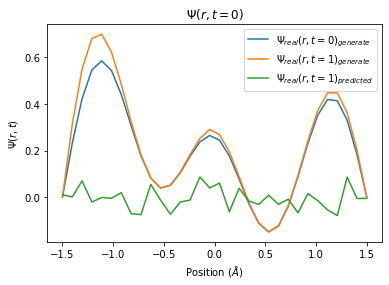

In [111]:
r_n = np.linspace(-1.5,1.5,32)
fig, ax = plt.subplots()
ax.set_title(r"$\Psi(r,t=0)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\Psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n, X1.real, label="$\Psi_{real}(r, t=0)_{generate}$")
ax.plot(r_n, Y1.real, label="$\Psi_{real}(r, t=1)_{generate}$")

ax.plot(r_n, y1_r, label="$\Psi_{real}(r, t=1)_{predicted}$")

ax.legend()
plt.show()